In [1]:

SHOW_MPL_TICKS_AND_LABELS = True
IMPORT_JSONS_FROM_DB = True
# Python Standard Library imports
from collections import defaultdict
from math import floor, ceil
from typing import Generator, Optional, List
import datetime
import itertools
import os
import requests
import time
from datetime import datetime, timedelta
from scipy.ndimage import maximum_filter
from tqdm import tqdm  # Import tqdm for progress bar
from scipy.ndimage import maximum_filter

# Python Non-Standard Library imports
from matplotlib.ticker import MaxNLocator
from dateutil.relativedelta import relativedelta
import matplotlib.cm as cm
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express.colors as pxcol
import plotly.graph_objects as go
from windrose import WindroseAxes, plot_windrose

# DYNAwind imports
# * Database
from dw_database.json import write_2_json
from dw_database.postgres import Postgres
from dw_config.location import Turbine
from dw_database.utils import make_dt_list, DynawindFrame
# * Signal
from dw_signal.signal import _bending_moment_2_stress, _area_moment_of_inertia
# * Fatigue
import dw_fatigue as fat
from py_fatigue.cycle_count.cycle_count import pbar_sum
import py_fatigue as pf


# * max nr of rows. Set to as much as you wish
pd.set_option('display.max_rows', 200)
# * max nr of columns. Set to as much as you wish
pd.set_option('display.max_columns', 100)
# * display width. Beyond it a scrollbar is shown
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family': 'Arial',       # Use 'Helvetica' if preferred
    'pdf.fonttype': 42,           # Embed TrueType fonts (required for Arial)
    'ps.fonttype': 42             # Same for EPS
})

plt.rcParams['font.family'] = 'Arial'  # Use only one font
plt.rcParams['font.size'] = 10

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from scipy.stats import norm, mvn, lognorm
from scipy.special import gamma, gammaincc

from scipy.stats import weibull_min
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.interpolate import griddata


# Geometric Parameter Functions

In [4]:
def moment_of_inertia(outer_diameter, wall_thickness):
    # Calculate inner diameter
    inner_diameter = outer_diameter - 2 * wall_thickness
    
    # Calculate the moment of inertia
    I = (np.pi / 64) * (outer_diameter**4 - inner_diameter**4)
    
    return I

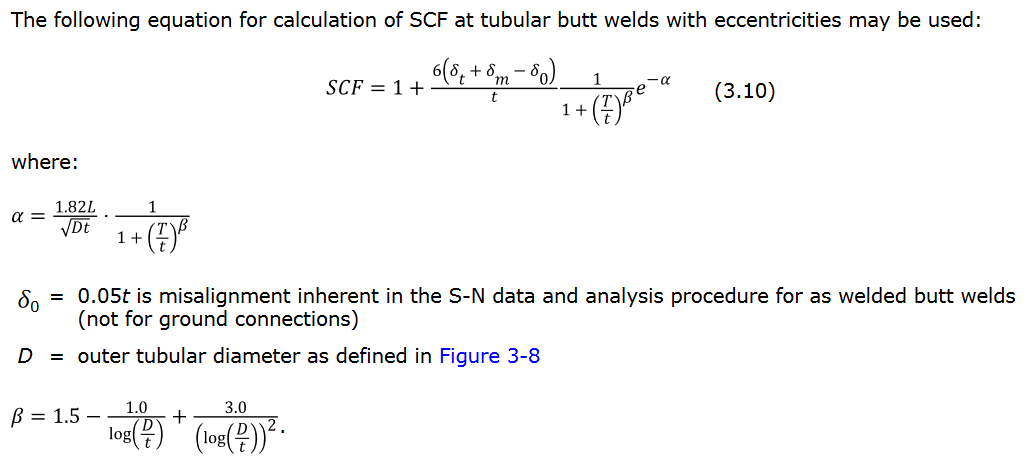

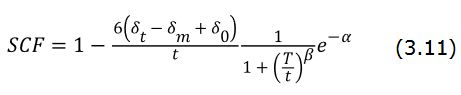
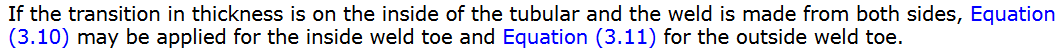

In [ ]:
import numpy as np

display(np.log(3/2))
display(-np.log(2/3))

In [ ]:
#DNV RP-C203 Section 3.3.7.3
def Stress_Concentration_Factor(outer_diameter, t, T, cans_misalignment):
    del_m = cans_misalignment
    del_nt = 0.05*t
    del_t = (T-t)/2
    
    # Calculate transition length
    L = (T-t)*4
    
    # Calculate the moment of inertia
    temp = np.log10(outer_diameter/t)
    beta = 1.5-(1/temp)+(3/(temp**2))
    alpha = 1.82*L/(((outer_diameter*t)**0.5)*(1+(T/t)**beta))

    temp2 = np.exp(-alpha)/((1+(T/t)**beta))
    SCF_in = 1+6*((del_t+del_m-del_nt)/t)*temp2
    SCF_out = 1-6*((del_t-del_m+del_nt)/t)*temp2
    
    return SCF_in, SCF_out


In [6]:
def Scale_Effect(outer_diameter, t, t_ref, t_eff_allowance, t_corr_exponent, weld_width):

    t_eff = np.minimum(14 + 0.66 * (weld_width + t_eff_allowance), t)
    scale_factor = (t_eff/t_ref)**t_corr_exponent

    return scale_factor

# Defining SN Curves

In [7]:
sn1 = fat.SNCurve(
    slope=[3, 5], 
    intercept=[12.164, 15.606],
    #N_knee=1e7,
    environment = 'Air', 
    curve = 'DNV-D-A',
    norm = 'DNVGL-RP-C203/2016',
    color='r'
)

sn2 = fat.SNCurve(
    slope=[3], 
    intercept=[11.687], 
    environment = 'Free corrosion', 
    curve = 'DNV-D-W', 
    norm = 'DNVGL-RP-C203/2016',
    color='g'
)

sn3 = fat.SNCurve(
    slope=[3, 5], 
    intercept=[11.764, 15.606], 
    #N_knee=1e6, 
    environment = 'Water with cathodic protection', 
    curve = 'DNV-D-C', 
    norm = 'DNVGL-RP-C203/2016',
    color='b'
)

sn_lst = [sn1, sn2, sn3]

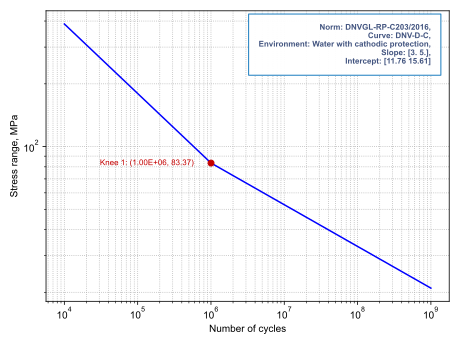

In [8]:
sn3

# Nominal Parameters

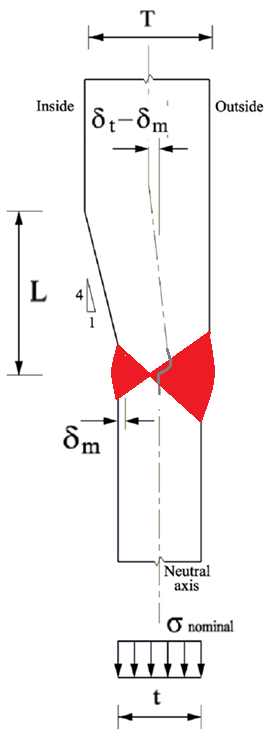


In [9]:
# Dimensions in mm
T_nom = 73
t_nom = 68
D_nom = 7200
misalignment_nom = 3

## Defining Tolerances and Distribution of Parameters

### Thicknesses and Diameter as truncated normal distributions

In [10]:
n_samples = 200000

In [11]:
# Smaller thickness Distribution (t)
t_tol_low = 0
t_tol_up = 3

L_t, U_t = t_nom+t_tol_low, t_nom+t_tol_up
mean_target_t, sigma_t = t_nom+0.01*t_nom, (t_tol_up-t_tol_low)/6   # ±3σ covers the range
a_t, b_t = (L_t - mean_target_t)/sigma_t, (U_t - mean_target_t)/sigma_t
trunc_t = truncnorm(a_t, b_t, loc=mean_target_t, scale=sigma_t)
samples_trunc_t = trunc_t.rvs(n_samples)

In [12]:
# Larger thickness Distribution (T)
T_tol_low = 0
T_tol_up = 3

L_T, U_T = T_nom+T_tol_low, T_nom+T_tol_up
mean_target_T, sigma_T = T_nom+0.01*T_nom, (T_tol_up-T_tol_low)/6
a_T, b_T = (L_T - mean_target_T)/sigma_T, (U_T - mean_target_T)/sigma_T
trunc_T = truncnorm(a_T, b_T, loc=mean_target_T, scale=sigma_T)
samples_trunc_T = trunc_T.rvs(n_samples)

In [13]:
# Outer diameter distribution (OD)
D_tol_low = -10
D_tol_up = 10

mean_target_D = D_nom
sigma_D = (D_tol_up-D_tol_low)/6
# Absolute bounds
L_D = D_nom + D_tol_low
U_D = D_nom + D_tol_up

# Standardized limits for truncnorm
a_D = (L_D - mean_target_D) / sigma_D
b_D = (U_D - mean_target_D) / sigma_D

# Create truncated normal distribution
trunc_D = truncnorm(a_D, b_D, loc=mean_target_D, scale=sigma_D)

samples_trunc_D = trunc_D.rvs(n_samples)

In [14]:
# misalignment distribution
L_cm, U_cm = 0, 10
mean_misalignment = misalignment_nom

sigma_cm = (U_cm - L_cm) / 6  

a_cm, b_cm = (L_cm - mean_misalignment) / sigma_cm, (U_cm - mean_misalignment) / sigma_cm

# Truncated normal distribution
trunc_misalignment = truncnorm(a_cm, b_cm, loc=mean_misalignment, scale=sigma_cm)
samples_misalignment = trunc_misalignment.rvs(n_samples)


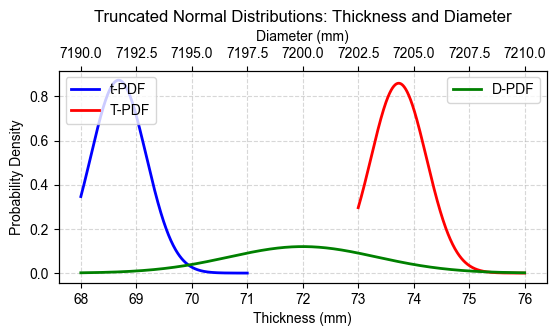

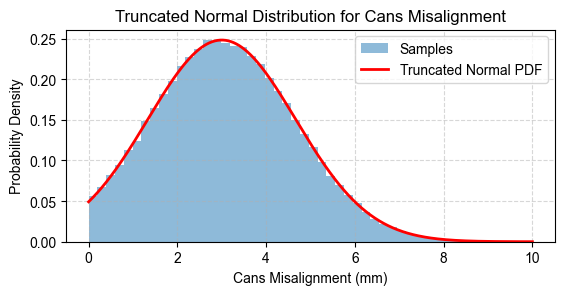

In [33]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots(figsize=(16/2.54, 7/2.54))

x_t = np.linspace(L_t, U_t, 500)
x_T = np.linspace(L_T, U_T, 500)
ax1.plot(x_t, trunc_t.pdf(x_t), 'b-', lw=2, label='t-PDF')
ax1.plot(x_T, trunc_T.pdf(x_T), 'r-', lw=2, label='T-PDF')
ax1.set_xlabel("Thickness (mm)")
ax1.set_ylabel("Probability Density")
ax1.legend(loc='upper left')
ax1.grid(True, linestyle="--", alpha=0.5)

# Secondary axis for D
ax2 = ax1.twiny()
x_D = np.linspace(mean_target_D + D_tol_low, mean_target_D + D_tol_up, 1000)

ax2.plot(x_D, trunc_D.pdf(x_D), 'g-', lw=2, label='D-PDF')
ax2.set_xlabel("Diameter (mm)")
ax2.legend(loc='upper right')

plt.title("Truncated Normal Distributions: Thickness and Diameter")
plt.show()


# Plot
x_cm = np.linspace(L_cm, U_cm, 500)
plt.figure(figsize=(16/2.54, 7/2.54))


plt.hist(samples_misalignment, bins=50, density=True, alpha=0.5, label='Samples')
plt.plot(x_cm, trunc_misalignment.pdf(x_cm), 'r-', lw=2, label='Truncated Normal PDF')
plt.xlabel('Cans Misalignment (mm)')
plt.ylabel('Probability Density')
plt.title('Truncated Normal Distribution for Cans Misalignment')
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# Design Stress Range Distribution

## Defining SN Curve (Sea water with Cathodic Protection)

In [16]:
sn = sn3
m1, m2 = sn.slope
loga1, loga2 = sn.intercept
S = sn.get_knee_stress()[0]  # Stress range at knee point

## Design Lifetime, DFF and weibull shape

In [17]:
n = 0.16*3600*24*365  # number of cycles per year--defined in standard
h = 0.8  # Weibull shape parameter--fixed by design standard
T = 20  # lifetime
FDF = 3  # Fatigue design factor--based on reliability at end of life


In [18]:
weld_width_nom = 0.64*t_nom

#Usually fixed for SN curves
t_ref = 25

#A safety margin in effective thickness calculation DNV-RP-C-203
t_eff_allowance = 6

#Fixed for SN curves from DNV
t_corr_exponent = 0.2

In [19]:
I_nominal = moment_of_inertia(D_nom,t_nom)
SCF_nom = Stress_Concentration_Factor(D_nom,t_nom,T_nom,misalignment_nom)
scale_f_nom = Scale_Effect(D_nom,t_nom, t_ref, t_eff_allowance, t_corr_exponent, weld_width_nom)


section_mod_nom_in = (I_nominal/((D_nom-2*(t_nom))/2))
section_mod_nom_out = (I_nominal/(D_nom/2))

section_mod_nominal = section_mod_nom_in

SEF_in = (section_mod_nominal/section_mod_nom_in)
SEF_out = (section_mod_nominal/section_mod_nom_out)

Material_F = 1.25

SMF_IN_nom = SEF_in*SCF_nom[0]*scale_f_nom*Material_F
SMF_OUT_nom = SEF_out*SCF_nom[1]*scale_f_nom*Material_F

SMF_IN_nom, SMF_OUT_nom

(1.5364633296719403, 1.274423917069962)

In [20]:

# Deterministic Analysis to find Weibull Scale Parameter %%
a1 = 10**loga1
a2 = 10**loga2
D_cr = 1 / FDF
q = 2  # initial value of scale parameter
thr = 1  # initial threshold value

#Defining the stress multiplication factor for design
SMF_nom = SMF_IN_nom

# Iteratively solve for the Weibull scale parameter [determining the loading distribution that causes damage equalling the critical damage in 20 years]
while thr > 1e-6:    
    qeff = q* SMF_nom  # Stress multilication factor conatining thickness correction, SCF and extrapolation factor to scale the stresses
    Seff = S* SMF_nom 
    G1 = gamma(1 + m1/h) * gammaincc(1 + m1/h, (Seff/qeff)**h)
    G2 = gamma(1 + m2/h) * (1 - gammaincc(1 + m2/h, (Seff/qeff)**h))
    D = T * n * ((qeff)**m1 / a1 * G1 + (qeff)**m2 / a2 * G2) # Deterministic method to calculate damage using 2 slope sn curve and stress range distribution
    thr = D_cr - D
    q += 1e-4

q_mean = q
q_mean

4.291000000003542

In [21]:
## Cross checking the design fatigue life
q = q_mean

qeff = q* SMF_nom  # Thickness correction factors to scale the stresses!
Seff = S* SMF_nom  # Thickness correction factors to scale the knee point!
G1 = gamma(1 + m1/h) * gammaincc(1 + m1/h, (Seff/qeff)**h)
G2 = gamma(1 + m2/h) * (1 - gammaincc(1 + m2/h, (Seff/qeff)**h))
#D = n * (q**m1 * 2**(0.2*m1)  / a1 * G1 + q**m2 * 2**(0.2*m2)  / a2 * G2) # thickness correction
D = n * ((qeff)**m1 / a1 * G1 + (qeff)**m2 / a2 * G2)

FL_nom = (1/FDF)*(1/D)
print(FL_nom)

19.99583015821698


In [22]:
bin_edges_stress = np.append(np.arange(0, 30, 0.5), np.inf) 

In [23]:
# Parameters
k = 0.8  # shape
lambda_ = q_mean  # scale
# Points where you want to evaluate the CDF
x = bin_edges_stress
# Compute CDF
cdf = weibull_min.cdf(x, c=k, scale=lambda_)
pdf = np.diff(cdf)
print(sum(pdf)) # this has to be always one

1.0


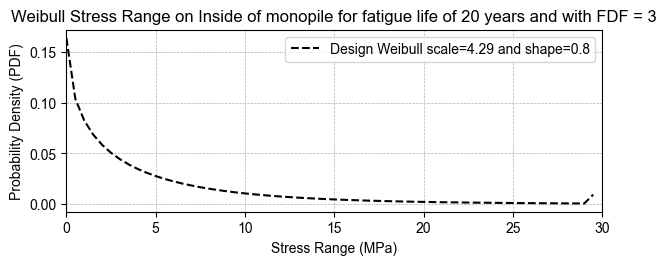

In [24]:
plt.figure(figsize=(16/2.54, 7/2.54))
plt.plot(x[:-1], np.diff(weibull_min.cdf(x, c=k, scale=lambda_)), 
         label=f"Design Weibull scale={lambda_:.2f} and shape={k}", linestyle='--', color='black')


plt.xlim([0, 30])
plt.xlabel("Stress Range (MPa)")
plt.ylabel("Probability Density (PDF)")
plt.title(f"Weibull Stress Range on Inside of monopile for fatigue life of {T} years and with FDF = {FDF}")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Stress Multiplication Factors

In [25]:
t_range = np.linspace(t_nom, t_nom+t_tol_up, 20)             # Thickness t
T_range = np.linspace(T_nom, T_nom+T_tol_up, 20)             # Thickness T
D_range = np.linspace(D_nom+D_tol_low, D_nom+D_tol_up, 21)         # Diameter D
misalignment_range = np.linspace(L_cm, U_cm, 21)   # Misalignment


# Create a 4D meshgrid
t_grid, T_grid, D_grid, mis_grid = np.meshgrid(
    t_range, T_range, D_range, misalignment_range, indexing='ij'
)

weld_width_grid = 0.64 * t_grid  # Usual weld width

I_grid = moment_of_inertia(D_grid, t_grid)

SCF_in_grid, SCF_out_grid = Stress_Concentration_Factor(D_grid, t_grid, T_grid, mis_grid)

scale_f_grid = Scale_Effect(D_grid, t_grid, t_ref, t_eff_allowance, t_corr_exponent, weld_width_grid )

section_mod_out_grid = I_grid / (D_grid / 2)
section_mod_in_grid = (I_grid/((D_grid-2*(t_grid))/2))

SEF_out_grid = section_mod_nom_in / section_mod_out_grid
SEF_in_grid = section_mod_nom_in / section_mod_in_grid

SMF_IN_grid = SCF_in_grid * scale_f_grid * SEF_in_grid * Material_F
SMF_OUT_grid = SCF_out_grid * scale_f_grid * SEF_out_grid * Material_F
        

df = pd.DataFrame({
    't': t_grid.ravel(),
    'T': T_grid.ravel(),
    'D': D_grid.ravel(),
    'misalignment': mis_grid.ravel(),
    'I': I_grid.ravel(),
    'SCF_in': SCF_in_grid.ravel(),
    'SCF_out': SCF_out_grid.ravel(),
    'scale_f': scale_f_grid.ravel(),
    'section_mod_out': section_mod_out_grid.ravel(),
    'section_mod_in': section_mod_in_grid.ravel(),
    'SEF_in': SEF_in_grid.ravel(),
    'SEF_out': SEF_out_grid.ravel(),
    'SMF_IN': SMF_IN_grid.ravel(),
    'SMF_OUT': SMF_OUT_grid.ravel()
})

## Fatigue life calculation using design loadings and ranges of stress multiplication factors

In [26]:
q = q_mean

qeff = q* df['SMF_IN'].values  # Thickness correction factors to scale the stresses!
Seff = S* df['SMF_IN'].values  # Thickness correction factors to scale the knee point!
G1 = gamma(1 + m1/h) * gammaincc(1 + m1/h, (Seff/qeff)**h)
G2 = gamma(1 + m2/h) * (1 - gammaincc(1 + m2/h, (Seff/qeff)**h))
#D = n * (q**m1 * 2**(0.2*m1)  / a1 * G1 + q**m2 * 2**(0.2*m2)  / a2 * G2) # thickness correction
D = n * ((qeff)**m1 / a1 * G1 + (qeff)**m2 / a2 * G2)
df['Fatigue_life_IN'] = (1/FDF)*(1/D)


qeff = q* df['SMF_OUT'].values  # Thickness correction factors to scale the stresses!
Seff = S* df['SMF_OUT'].values  # Thickness correction factors to scale the knee point!
G1 = gamma(1 + m1/h) * gammaincc(1 + m1/h, (Seff/qeff)**h)
G2 = gamma(1 + m2/h) * (1 - gammaincc(1 + m2/h, (Seff/qeff)**h))
#D = n * (q**m1 * 2**(0.2*m1)  / a1 * G1 + q**m2 * 2**(0.2*m2)  / a2 * G2) # thickness correction
D = n * ((qeff)**m1 / a1 * G1 + (qeff)**m2 / a2 * G2)
df['Fatigue_life_OUT'] = (1/FDF)*(1/D)

In [27]:
df

,t,T,D,misalignment,I,SCF_in,SCF_out,scale_f,section_mod_out,section_mod_in,SEF_in,SEF_out,SMF_IN,SMF_OUT,Fatigue_life_IN,Fatigue_life_OUT
0,68.0,73.0,7190.0,0.0,9.647489e+12,0.963638,0.761630,1.133037,2.683585e+09,2.735324e+09,1.002796,1.022130,1.368614,1.102565,35.337614,101.753974
1,68.0,73.0,7190.0,0.5,9.647489e+12,0.983839,0.781831,1.133037,2.683585e+09,2.735324e+09,1.002796,1.022130,1.397305,1.131809,31.911941,89.568736
2,68.0,73.0,7190.0,1.0,9.647489e+12,1.004040,0.802032,1.133037,2.683585e+09,2.735324e+09,1.002796,1.022130,1.425995,1.161052,28.876220,79.087508
3,68.0,73.0,7190.0,1.5,9.647489e+12,1.024241,0.822232,1.133037,2.683585e+09,2.735324e+09,1.002796,1.022130,1.454685,1.190296,26.179748,70.039518
4,68.0,73.0,7190.0,2.0,9.647489e+12,1.044442,0.842433,1.133037,2.683585e+09,2.735324e+09,1.002796,1.022130,1.483376,1.219539,23.779203,62.201926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176395,71.0,76.0,7210.0,8.0,1.014550e+13,1.269698,1.075671,1.139123,2.814285e+09,2.870825e+09,0.955465,0.974661,1.727411,1.492840,11.213292,23.045737
176396,71.0,76.0,7210.0,8.5,1.014550e+13,1.289101,1.095073,1.139123,2.814285e+09,2.870825e+09,0.955465,0.974661,1.753808,1.519768,10.403039,21.102376
176397,71.0,76.0,7210.0,9.0,1.014550e+13,1.308503,1.114476,1.139123,2.814285e+09,2.870825e+09,0.955465,0.974661,1.780206,1.546695,9.661926,19.351988
176398,71.0,76.0,7210.0,9.5,1.014550e+13,1.327906,1.133879,1.139123,2.814285e+09,2.870825e+09,0.955465,0.974661,1.806603,1.573623,8.983179,17.772626


In [28]:
D_fix = 7200
mis_fix = 3
tol = 1e-3

df_slice = df[
    (np.abs(df['D'] - D_fix) < tol) &
    (np.abs(df['misalignment'] - mis_fix) < tol)
]
df_slice

,t,T,D,misalignment,I,SCF_in,SCF_out,scale_f,section_mod_out,section_mod_in,SEF_in,SEF_out,SMF_IN,SMF_OUT,Fatigue_life_IN,Fatigue_life_OUT
216,68.0,73.000000,7200.0,3.0,9.688182e+12,1.084846,0.882832,1.133037,2.691162e+09,2.742973e+09,1.000000,1.019253,1.536463,1.274424,19.995830,50.141244
657,68.0,73.157895,7200.0,3.0,9.688182e+12,1.087797,0.879968,1.133037,2.691162e+09,2.742973e+09,1.000000,1.019253,1.540643,1.270291,19.729787,50.945840
1098,68.0,73.315789,7200.0,3.0,9.688182e+12,1.090732,0.877121,1.133037,2.691162e+09,2.742973e+09,1.000000,1.019253,1.544799,1.266180,19.469404,51.761322
1539,68.0,73.473684,7200.0,3.0,9.688182e+12,1.093650,0.874290,1.133037,2.691162e+09,2.742973e+09,1.000000,1.019253,1.548933,1.262093,19.214528,52.587802
1980,68.0,73.631579,7200.0,3.0,9.688182e+12,1.096552,0.871474,1.133037,2.691162e+09,2.742973e+09,1.000000,1.019253,1.553043,1.258028,18.965008,53.425392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174411,71.0,75.368421,7200.0,3.0,1.010293e+13,1.064088,0.892774,1.139123,2.806368e+09,2.862830e+09,0.958134,0.977410,1.451724,1.242508,26.443713,56.773770
174852,71.0,75.526316,7200.0,3.0,1.010293e+13,1.067006,0.889970,1.139123,2.806368e+09,2.862830e+09,0.958134,0.977410,1.455705,1.238604,26.089551,57.655024
175293,71.0,75.684211,7200.0,3.0,1.010293e+13,1.069909,0.887180,1.139123,2.806368e+09,2.862830e+09,0.958134,0.977410,1.459666,1.234722,25.742903,58.547789
175734,71.0,75.842105,7200.0,3.0,1.010293e+13,1.072797,0.884406,1.139123,2.806368e+09,2.862830e+09,0.958134,0.977410,1.463605,1.230861,25.403563,59.452178


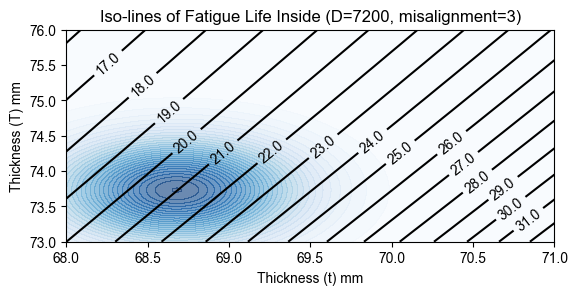

In [29]:
# Pivot DataFrame into a 2D grid
pivot = df_slice.pivot_table(
    index="t", columns="T", values="Fatigue_life_IN"
)

# Extract coordinates
t_unique = pivot.index.values
T_unique = pivot.columns.values
SMF_grid_2D = pivot.values

min_val, max_val = SMF_grid_2D.min(), SMF_grid_2D.max()
levels = np.arange(np.floor(min_val), np.ceil(max_val) + 0.5, 0.5)

t_mesh, T_mesh = np.meshgrid(t_unique, T_unique, indexing='ij')


# For PDFs
t_fine = np.linspace(t_unique.min(), t_unique.max(), 200)
T_fine = np.linspace(T_unique.min(), T_unique.max(), 200)
t_fine_mesh, T_fine_mesh = np.meshgrid(t_fine, T_fine, indexing='ij')

# Joint PDF
pdf_t = trunc_t.pdf(t_fine_mesh)
pdf_T = trunc_T.pdf(T_fine_mesh)
joint_pdf = pdf_t * pdf_T



plt.figure(figsize=(16/2.54, 7/2.54))

# Background joint probability
plt.contourf(t_fine_mesh, T_fine_mesh, joint_pdf, levels=30, cmap="Blues", alpha=0.6)

# Contour plot
contour = plt.contour(t_mesh, T_mesh, SMF_grid_2D, levels=20, colors='k')
plt.clabel(contour, inline=True, fontsize=10, fmt='%1.1f')  # Label the contourscontour = plt.contour(t_mesh, T_mesh, SMF_grid_2D, levels=levels, 

# Labels
plt.xlabel('Thickness (t) mm')
plt.ylabel('Thickness (T) mm')
plt.title(f'Iso-lines of Fatigue Life Inside (D={D_fix}, misalignment={mis_fix})')
plt.show()

In [30]:
t_fix = 68
T_fix = 73
tol = 1e-3

df_slice_ = df[
    (np.abs(df['t'] - t_fix) < tol) &
    (np.abs(df['T'] - T_fix) < tol)
]
df_slice_

,t,T,D,misalignment,I,SCF_in,SCF_out,scale_f,section_mod_out,section_mod_in,SEF_in,SEF_out,SMF_IN,SMF_OUT,Fatigue_life_IN,Fatigue_life_OUT
0,68.0,73.0,7190.0,0.0,9.647489e+12,0.963638,0.761630,1.133037,2.683585e+09,2.735324e+09,1.002796,1.022130,1.368614,1.102565,35.337614,101.753974
1,68.0,73.0,7190.0,0.5,9.647489e+12,0.983839,0.781831,1.133037,2.683585e+09,2.735324e+09,1.002796,1.022130,1.397305,1.131809,31.911941,89.568736
2,68.0,73.0,7190.0,1.0,9.647489e+12,1.004040,0.802032,1.133037,2.683585e+09,2.735324e+09,1.002796,1.022130,1.425995,1.161052,28.876220,79.087508
3,68.0,73.0,7190.0,1.5,9.647489e+12,1.024241,0.822232,1.133037,2.683585e+09,2.735324e+09,1.002796,1.022130,1.454685,1.190296,26.179748,70.039518
4,68.0,73.0,7190.0,2.0,9.647489e+12,1.044442,0.842433,1.133037,2.683585e+09,2.735324e+09,1.002796,1.022130,1.483376,1.219539,23.779203,62.201926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,68.0,73.0,7210.0,8.0,9.728989e+12,1.286868,1.084848,1.133037,2.698749e+09,2.750633e+09,0.997215,1.016387,1.817511,1.561645,8.719466,18.455325
437,68.0,73.0,7210.0,8.5,9.728989e+12,1.307070,1.105050,1.133037,2.698749e+09,2.750633e+09,0.997215,1.016387,1.846043,1.590726,8.072345,16.849475
438,68.0,73.0,7210.0,9.0,9.728989e+12,1.327272,1.125252,1.133037,2.698749e+09,2.750633e+09,0.997215,1.016387,1.874576,1.619807,7.481926,15.408105
439,68.0,73.0,7210.0,9.5,9.728989e+12,1.347474,1.145454,1.133037,2.698749e+09,2.750633e+09,0.997215,1.016387,1.903108,1.648887,6.942506,14.111926


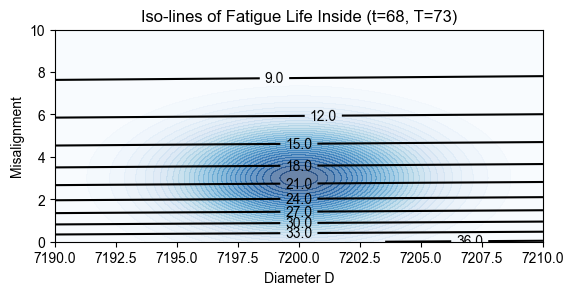

In [31]:
pivot = df_slice_.pivot_table(
    index="D", columns="misalignment", values="Fatigue_life_IN"
)

D_unique = pivot.index.values
misalignment_unique = pivot.columns.values
SMF_grid_2D = pivot.values

min_val, max_val = SMF_grid_2D.min(), SMF_grid_2D.max()
levels = np.arange(np.floor(min_val), np.ceil(max_val) + 0.5, 0.5)

D_mesh, mis_mesh = np.meshgrid(D_unique, misalignment_unique, indexing='ij')


# grid for PDFs
D_fine = np.linspace(D_unique.min(), D_unique.max(), 200)
mis_fine = np.linspace(misalignment_unique.min(), misalignment_unique.max(), 200)
D_fine_mesh, mis_fine_mesh = np.meshgrid(D_fine, mis_fine, indexing='ij')

# Joint PDF
pdf_D = trunc_D.pdf(D_fine_mesh)
pdf_mis = trunc_misalignment.pdf(mis_fine_mesh)
joint_pdf = pdf_D * pdf_mis


plt.figure(figsize=(16/2.54, 7/2.54))

plt.contourf(D_fine_mesh, mis_fine_mesh, joint_pdf, levels=35, cmap="Blues", alpha=0.6)

# Contour plot of Fatigue Life
contour = plt.contour(D_mesh, mis_mesh, SMF_grid_2D, levels=10, colors='k')
plt.clabel(contour, inline=True, fontsize=10, fmt='%1.1f')

# Labels
plt.xlabel('Diameter D')
plt.ylabel('Misalignment')
plt.title(f'Iso-lines of Fatigue Life Inside (t={t_fix}, T={T_fix})')
#plt.yticks(np.arange(misalignment_unique.min(), misalignment_unique.max() + 0.5, 1))  # step size 0.5

plt.show()

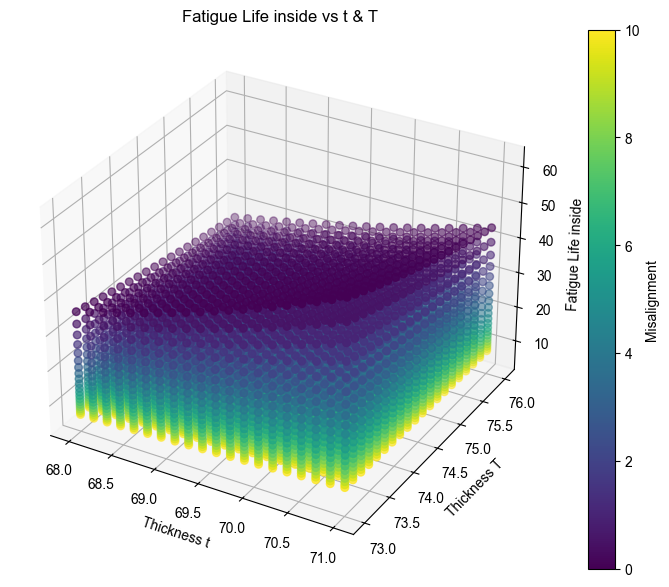

In [32]:
from mpl_toolkits.mplot3d import Axes3D

# Slice or select your data
df_slice_3D = df[np.isclose(df["D"], D_fix, atol=1e-3)]  # fix diameter

# Extract values
t_vals = df_slice_3D["t"].values
T_vals = df_slice_3D["T"].values
life_vals = df_slice_3D["Fatigue_life_IN"].values
mis_vals = df_slice_3D["misalignment"].values  

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

p = ax.scatter(
    t_vals, T_vals, life_vals,
    c=mis_vals, cmap="viridis", s=30
)

ax.set_xlabel("Thickness t")
ax.set_ylabel("Thickness T")
ax.set_zlabel("Fatigue Life inside")
ax.set_title("Fatigue Life inside vs t & T")
fig.colorbar(p, ax=ax, label="Misalignment")
plt.show()


In [5]:
from owilab_torque2026 import fatigue_damage_two_slope, solve_weibull_scale_for_damage
import numpy as np

q = solve_weibull_scale_for_damage(
    m1=3.0, m2=5.0, log_a1=0.0, log_a2=0.0, s_knee=0.0, h=2.0,
    t_years=1.0, n_per_year=1.0, fdf=1.0, smf=1.0, q0=0.0,
    step=1e-3, tol=1e-6, max_iter=100000,
)
d = fatigue_damage_two_slope(q, 0.0, 3.0, 5.0, 1.0, 1.0, 2.0, 1.0)
np.isclose(d, 1.0, atol=6e-3)

np.True_